In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline  
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib import colors
from matplotlib import cm


df_post=pd.read_csv("CrimebyPostcode.csv",encoding = "cp1252")
df_post.head()

,Postcode,y_2012,y_2013,y_2014,y_2015,y_2016
0,3000,25046,22604,21816,22158,23715
1,3002,788,1044,716,817,854
2,3003,626,566,472,606,780
3,3004,188,115,185,143,35
4,3006,1993,2164,2474,2895,3288


c:\users\deepu\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\mpl_toolkits\basemap\__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
c:\users\deepu\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\mpl_toolkits\basemap\__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


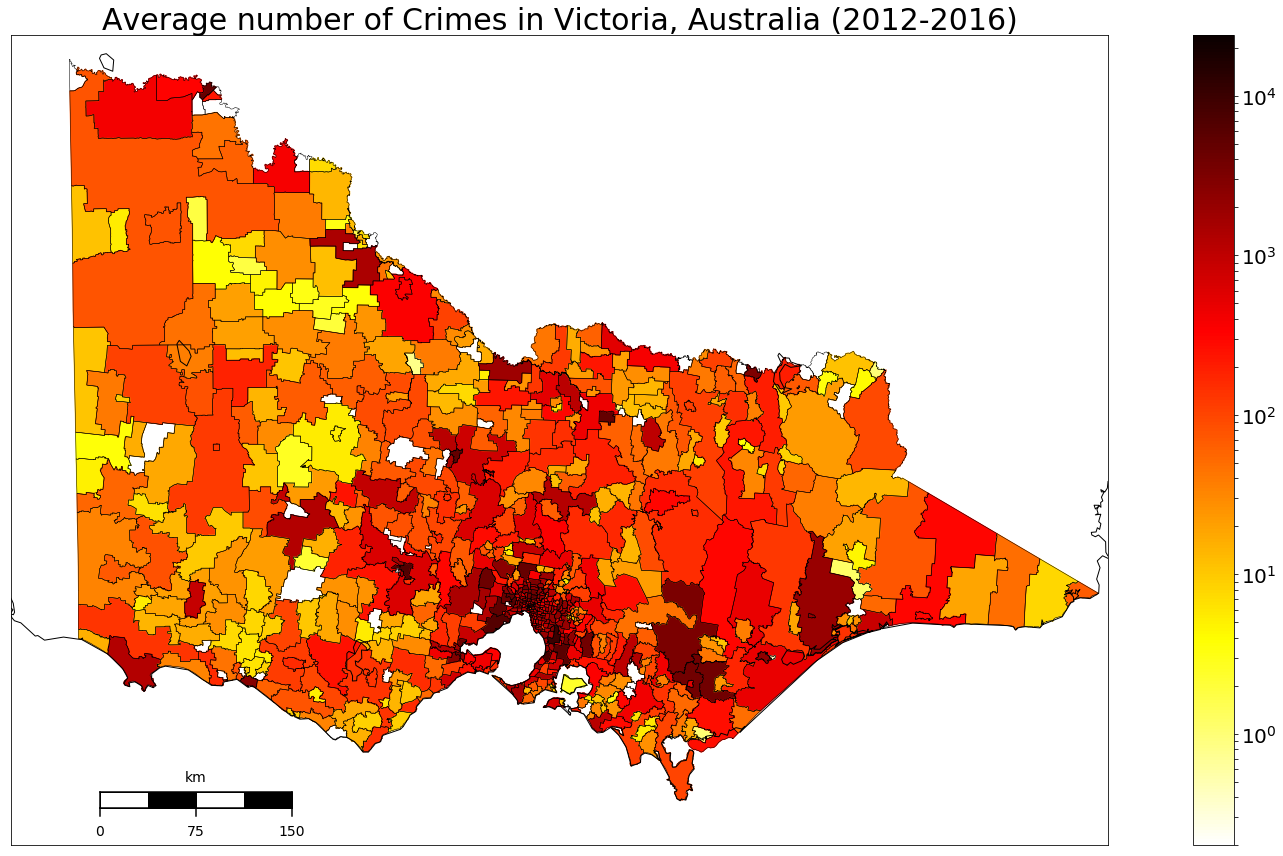

In [2]:
df_post=df_post.set_index('Postcode')
df_post=df_post.filter(regex='y_')
crime_zip=df_post.mean(axis=1)
crime_zip.max()

#function for removing duplicates and preserving order
def de_dup(seq): 
   # order preserving
   check = []
   for i in seq:
       if i not in check:
           check.append(i)
   return check


fig,ax=plt.subplots(figsize=(24,12)) #initialize size of figure



#generate the base map and enter longitude and latitude values for lowerleft corner, upper right corner and center of the image
#This generates the basic or base map upon which we overlay the data
map = Basemap(llcrnrlon=140.32,llcrnrlat=-39.5,urcrnrlon=149.7,urcrnrlat=-33.60679,
             resolution='i', projection='tmerc', lat_0 = -39, lon_0 = 142.44,width = 980, height=686)

#map.drawmapboundary(fill_color='aqua') #option to add colours
#map.fillcontinents(color='white')
map.drawcoastlines() #Draw the coastline

#Obtained Shape file (.shp) from Vic government website, which has name, postcode and shape (polygon) of each of the areas
#https://www.data.vic.gov.au/data/dataset/postcode-boundaries-polygon-vicmap-admin

map.readshapefile('vmlite_postcode_polygon', 'VIC',drawbounds=True) 


#list to store postcodes from the shape file
postcodes=[]

# set the value range (Crime number range)
vmin = 0
vmax = 24000

#map.Vic_info has the metadata, or info such as postcode, name, etc.... generate a file with postcodes from the shapes file
#need to keep the order of this as it matches with the indexing in the coordinate file (map.VIC)

for shape in map.VIC_info:
    #access the postcode within the info file and conver into int
    postcode=int(shape['POSTCODE']) 
    postcodes.append(postcode)

#remove duplicate postcodes from list using de_dup function defined earlier
postcodes=de_dup(postcodes)   

#convert to np array for use with masks
postcodes=np.array(postcodes) 

#deleting values not shared between arrays

crimes1=crime_zip.index.values #zip codes from the crime data file stored as a list

#Inorder to account for differences in postcodes (deletions or additions), a mask is created using np.in1d
#create a mask with condition, is values in crimes1 present in postcodes
mask=np.in1d(crimes1,postcodes)
crimes_match=crimes1[mask] 

#Do it the otherway around
crimes_match=de_dup(crimes_match)
mask2=np.in1d(postcodes,crimes_match)
postcodes=postcodes[mask2]

ax = plt.gca() # get current axes instance

logmin=0.1 #account for log-scaling,as log 0 is undefined and gives an error

#Define the colours to be used based on the crime number
#colours need to be normalized to the minimum and max value of the crime number
#Log Normalisation as it gives a better distribution across uneven ranges
norm=colors.LogNorm(vmin=max(crime_zip.values.min(),logmin),vmax=vmax)

#SCalarmappable makes use of data normalisation and converts scalar data (0-1) to RGBA values for a colour map (Greys, in this instant)
mapper=cm.ScalarMappable(norm=norm,cmap=cm.hot_r)

#dictionary to store postcode as key and the crime number will determine the RGB value, stored as corresponding value
niram={}

for i, v in enumerate(crime_zip):
    niram[crime_zip.index[i]]=mapper.to_rgba(v)[:3]  #returns rgba, where a is alpha. Do not need alpha so slicing it

i=0 #counter for map.VIC
j=0 #counter for psotcodes (this array is based on the info we have available about crime data) If no crime data, its not plotted


#loop to convert RGB values to Hex colour code and then fill the polygons (states) associated with postcodes with that colour
while i<len(map.VIC):
    map_code=int(map.VIC_info[i]['POSTCODE'])
    if map_code==postcodes[j]:
        #return Hex string for rgb or rgba sequence
        color = rgb2hex(niram[postcodes[j]]) 
        
        #Fill the polygon or shape (state) with the colour associated with its crime number
        poly = Polygon(map.VIC[i],facecolor=color,edgecolor=color)
        ax.add_patch(poly)
        j+=1
        i+=1
    else:
        i+=1

#setting a dummy array
mapper.set_array([])

#Creating a colour bar
cbar=plt.colorbar(mapper)
#change labelsize
cbar.ax.tick_params(labelsize=20)
#Graph title
plt.title("Average number of Crimes in Victoria, Australia (2012-2016)",fontsize=30)
plt.tight_layout()

#Draw Scale bar
map.drawmapscale(142,-39.2,143.5,-39.23,length=150,barstyle='fancy', labelstyle='simple',units='km',fontsize=14)
fig.savefig('Australia Crime stats.png',dpi=300)